# Mouse snRNA Integrative Analysis
## Gastrocnemius
### Data
- [Gastroc data table](https://github.com/erebboah/ENC4_Mouse_SingleCell/blob/master/snrna/ref/gastrocnemius_minimal_metadata.tsv)

### Aims
[integrate_parse_10x.R](https://github.com/erebboah/ENC4_Mouse_SingleCell/blob/master/snrna/scripts/integrate_parse_10x.R):
1. Read in pre-processed Parse and 10x data and merge counts matrices across experiments (within the same technology) for each tissue.
2. Filter nuclei by # genes, # UMIs, percent mitochondrial gene expression, and doublet score. See [detailed metadata](https://github.com/erebboah/ENC4_Mouse_SingleCell/blob/master/snrna/ref/enc4_mouse_snrna_metadata.tsv) for filter cutoffs. The adrenal gland filters are the same as the brain filters.
3. Run SCT on the 3 objects to regress `percent.mt` and `nFeature_RNA`. Use  `method = "glmGamPoi"` to speed up this step, and save pre-integrated data in `seurat` folder.
4. Combine Parse standard, Parse deep, and 10x data by CCA integration. Use Parse standard as reference dataset because it contains all timepoints, while 10x data only contains 2 timepoints. 
5. Score nuclei by cell cycle using these [mouse cell cycle genes](https://github.com/erebboah/ENC4_Mouse_SingleCell/blob/master/snrna/ref/mouse_cellcycle_genes.rda) to aid in manual celltype annotation.

**In this notebook**:
Manual celltype annotation.

### Results
- Seurat CCA works pretty well for integrating the 3 types of experiments: Parse standard, Parse deep, and 10x multiome. 


In [1]:
library(Matrix)
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(viridis))
library(glmGamPoi)
library(RColorBrewer)
options(future.globals.maxSize = 10000 * 1024^2)
future.seed=TRUE


Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"


In [2]:
setwd("../../enc4_mouse/snrna/")

ERROR: Error in setwd("../../enc4_mouse/snrna/"): cannot change working directory


In [2]:
setwd("/share/crsp/lab/seyedam/share/enc4_mouse/snrna/")

In [3]:
system("mkdir plots/gastrocnemius")
system("mkdir plots/gastrocnemius/qc")
system("mkdir plots/gastrocnemius/clustering")
system("mkdir plots/gastrocnemius/annotation")

# Functions

In [7]:
get_orig_counts = function(file){
    metadata = metadata[metadata$file_accession == file,]
    counts = readMM(paste0("counts_10x/",file,"/matrix.mtx"))
    
    barcodes = read.delim(paste0("counts_10x/",file,"/barcodes.tsv"),header = F, col.names="barcode")
    features = read.delim(paste0("counts_10x/",file,"/genes.tsv"),header = F, col.names="gene_name") 
    colnames(counts) = barcodes$barcode
    rownames(counts) = features$gene_name
    out = counts

}

In [8]:
knee_df = function(mtx,expt_name){
    df = as.data.frame(rowSums(mtx))
    colnames(df) = c("nUMI")
    df <- tibble(total = df$nUMI,
               rank = row_number(dplyr::desc(total))) %>%
    distinct() %>%
    arrange(rank)
    df$experiment = expt_name
    out = df
}

# QC plots

## Knee plot

In [4]:
combined.sct = readRDS("seurat/gastrocnemius_Parse_10x_integrated.rds")
cellbend_10x = subset(combined.sct,subset=technology =="10x")
orig_parse = subset(combined.sct,subset=technology =="Parse")
parse_standard = subset(orig_parse,subset=depth1 =="shallow")
parse_deep = subset(orig_parse,subset=depth1 =="deep")

In [10]:
metadata = read.delim("ref/enc4_mouse_snrna_metadata.tsv")
metadata = metadata[metadata$technology == "10x",]
metadata = metadata[metadata$tissue == "Gastrocnemius",]

files = metadata$file_accession

orig_10x = get_orig_counts(files[1])

for (j in 2:length(files)){
    counts_adding = get_orig_counts(files[j])
    orig_10x = cbind(orig_10x, counts_adding)
}


In [11]:
cellbend_knee_plot = knee_df(cellbend_10x@assays$RNA@counts, "10x + Cellbender")
orig_knee_plot = knee_df(orig_10x, "10x")

parse_standard_knee_plot = knee_df(parse_standard@assays$RNA@counts, "Parse standard")
parse_deep_knee_plot = knee_df(parse_deep@assays$RNA@counts, "Parse deep")

pdf(file="plots/gastrocnemius/qc/experiment_kneeplots.pdf",
    width = 10, height = 8)
ggplot(rbind(cellbend_knee_plot,orig_knee_plot,parse_standard_knee_plot,parse_deep_knee_plot), 
       aes(rank, total, group = experiment, color = experiment)) +
geom_path() + 
scale_y_log10() + scale_x_log10() + annotation_logticks() +
labs(y = "Total UMI count", x = "Barcode rank", title = "Mouse gastrocnemius knee plot") + 
geom_hline(yintercept=500, linetype="dashed", color = "red", size=1)
dev.off()


Warning message:
"Transformation introduced infinite values in continuous y-axis"


png 
  2

In [12]:
pdf(file="plots/gastrocnemius/qc/experiment_violinplots.pdf",
    width = 20, height = 5)
VlnPlot(combined.sct, features = c("nFeature_RNA"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0"))+ ggtitle("# genes per nucleus") +
stat_summary(fun.y = median, geom='point', size = 15, colour = "black", shape = 95) & theme(text = element_text(size = 20), 
                                                                              axis.text.x = element_text(size = 20), 
                                                                              axis.text.y = element_text(size = 20))
VlnPlot(combined.sct, features = c("nCount_RNA"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0")) + ggtitle("# UMIs per nucleus") +
stat_summary(fun.y = median, geom='point', size = 15, colour = "black", shape = 95)& theme(text = element_text(size = 20), 
                                                  axis.text.x = element_text(size = 20), 
                                                  axis.text.y = element_text(size = 20))
VlnPlot(combined.sct, features = c("percent.mt"), ncol = 1, split.by = "depth2",
        pt.size = 0, group.by = "sample", cols = c("#811b74","#C08DBA","#00a1e0")) & theme(text = element_text(size = 20), 
                                                  axis.text.x = element_text(size = 20), 
                                                  axis.text.y = element_text(size = 20)) 
dev.off()

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.

Warning message:
"`fun.y` is deprecated. Use `fun` instead."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"`fun.y` is deprecated. Use `fun` instead."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."


png 
  2

## UMAP "Feature Plots" of QC metadata

In [13]:
pdf(file="plots/gastrocnemius/qc/qc_featureplot.pdf",
    width = 25, height = 10)
FeaturePlot(combined.sct, pt.size = 0.1, order = T,
            features =c("nFeature_RNA",
                        "nCount_RNA",
                        "percent.mt",
                        "percent.ribo",
                        "doublet_scores",
                        "G2M.Score"), ncol =3)  & scale_colour_gradientn(colours = viridis(11)) & 
                        NoAxes()& 
                        theme(text = element_text(size = 20))

dev.off()


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



png 
  2

# Check integration and clustering

In [7]:
nclusters = length(unique(combined.sct$seurat_clusters))
cluster_cols = colorRampPalette(brewer.pal(9,"Set1"))(nclusters)

In [15]:
pdf(file="plots/gastrocnemius/UMAP_Parse_10x.pdf",
    width = 20, height = 8)
p1 <- DimPlot(combined.sct, reduction = "umap", group.by = "technology")
p2 <- DimPlot(combined.sct, reduction = "umap", label = TRUE, repel = TRUE, cols = cluster_cols)
p1 + p2

dev.off()

png 
  2

In [16]:
pdf(file="plots/gastrocnemius/Parse_10x_experiment_distribution.pdf",
    width = 20, height = 6)
DimPlot(combined.sct, reduction = "umap", group.by = "seurat_clusters",split.by = "depth2", label = TRUE, label.size = 6, repel = TRUE, shuffle = T,cols = cluster_cols)

ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=depth2)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20))

dev.off()


png 
  2

In [9]:
combined.sct$sample = factor(combined.sct$sample, levels=paste0("G_",rep(c("4","10","14","25","36","2m","18m"),each=4),rep(c("_M","_F"),each=2),c("_1","_2")))

pdf(file="plots/gastrocnemius/UMAP_cluster_sample_barplot.pdf",
    width = 20, height = 10)
p1=DimPlot(combined.sct, reduction = "umap", group.by = "seurat_clusters", label = TRUE, label.size = 8, repel = TRUE, 
          cols = cluster_cols)
p2=ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=sample)) + geom_bar(position = "fill") +
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()
gridExtra::grid.arrange(
  p1, p2,
  widths = c(2,1.6),
  layout_matrix = rbind(c(1, 2)))

dev.off()

png 
  2

In [10]:
pdf(file="plots/gastrocnemius/age_sex_barplot.pdf",
    width = 18, height = 19)
p1=DimPlot(combined.sct, reduction = "umap", group.by = "timepoint", label = TRUE, label.size = 5, repel = TRUE)
p2 = ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=timepoint)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()

p3=DimPlot(combined.sct, reduction = "umap", group.by = "sex", label = TRUE, label.size = 5, repel = TRUE, shuffle = T)
p4 = ggplot(combined.sct@meta.data, aes(x=seurat_clusters, fill=sex)) + geom_bar(position = "fill") & 
theme(text = element_text(size = 20), axis.text.x = element_text(size = 20), axis.text.y = element_text(size = 20)) & coord_flip()
gridExtra::grid.arrange(
  p1, p2, p3, p4,
  widths = c(2,1),
  layout_matrix = rbind(c(1, 2),
                        c(3, 4)))

dev.off()

png 
  2

### Dot plot of marker genes

In [15]:
genes = c("Myh1","Myh2","Myh3","Myh4","Myh6","Myh7","Myh8","Myh9","Myh10","Myh11","Myh13")

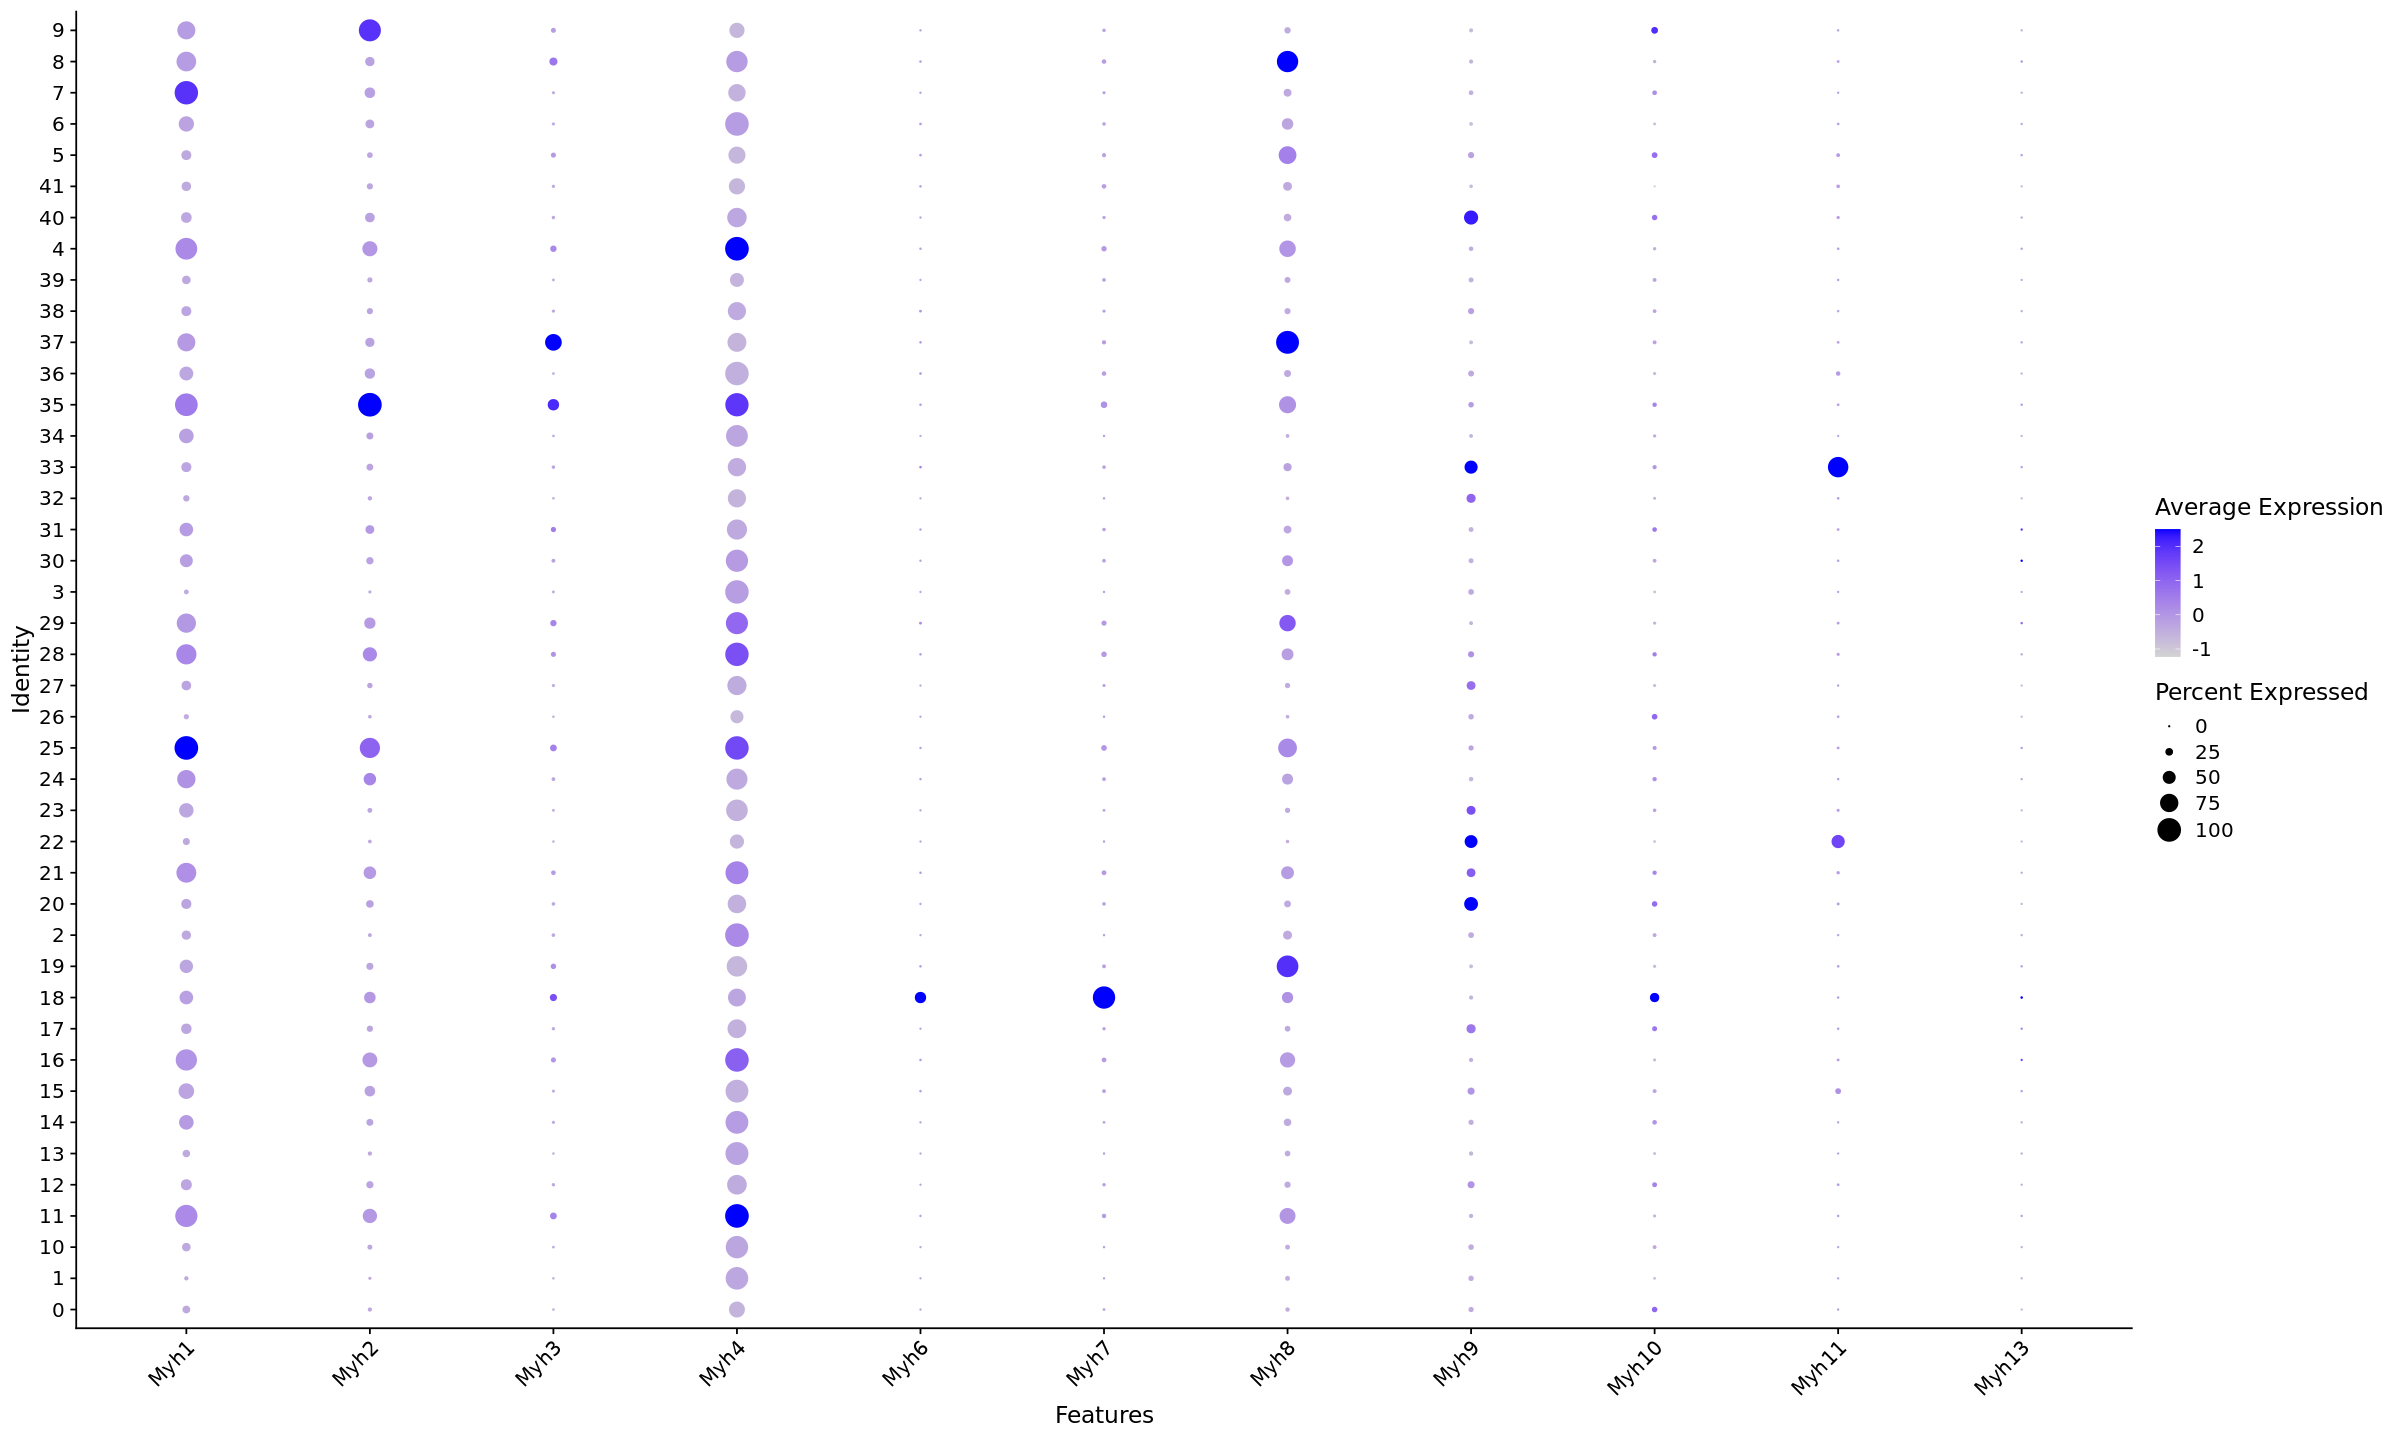

In [16]:
# https://panglaodb.se/markers.html
#pdf(file="plots/gastrocnemius/marker_dotplot.pdf",
#    width = 20, height = 12)

options(repr.plot.width=20, repr.plot.height=12)


DefaultAssay(combined.sct) = "SCT"
Idents(combined.sct) = "seurat_clusters"
Idents(combined.sct) = factor(Idents(combined.sct), levels = sort(as.character(unique(Idents(combined.sct)))))
DotPlot(combined.sct, features = genes)+ 
theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
#dev.off()

### FeaturePlots of marker genes

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will rep

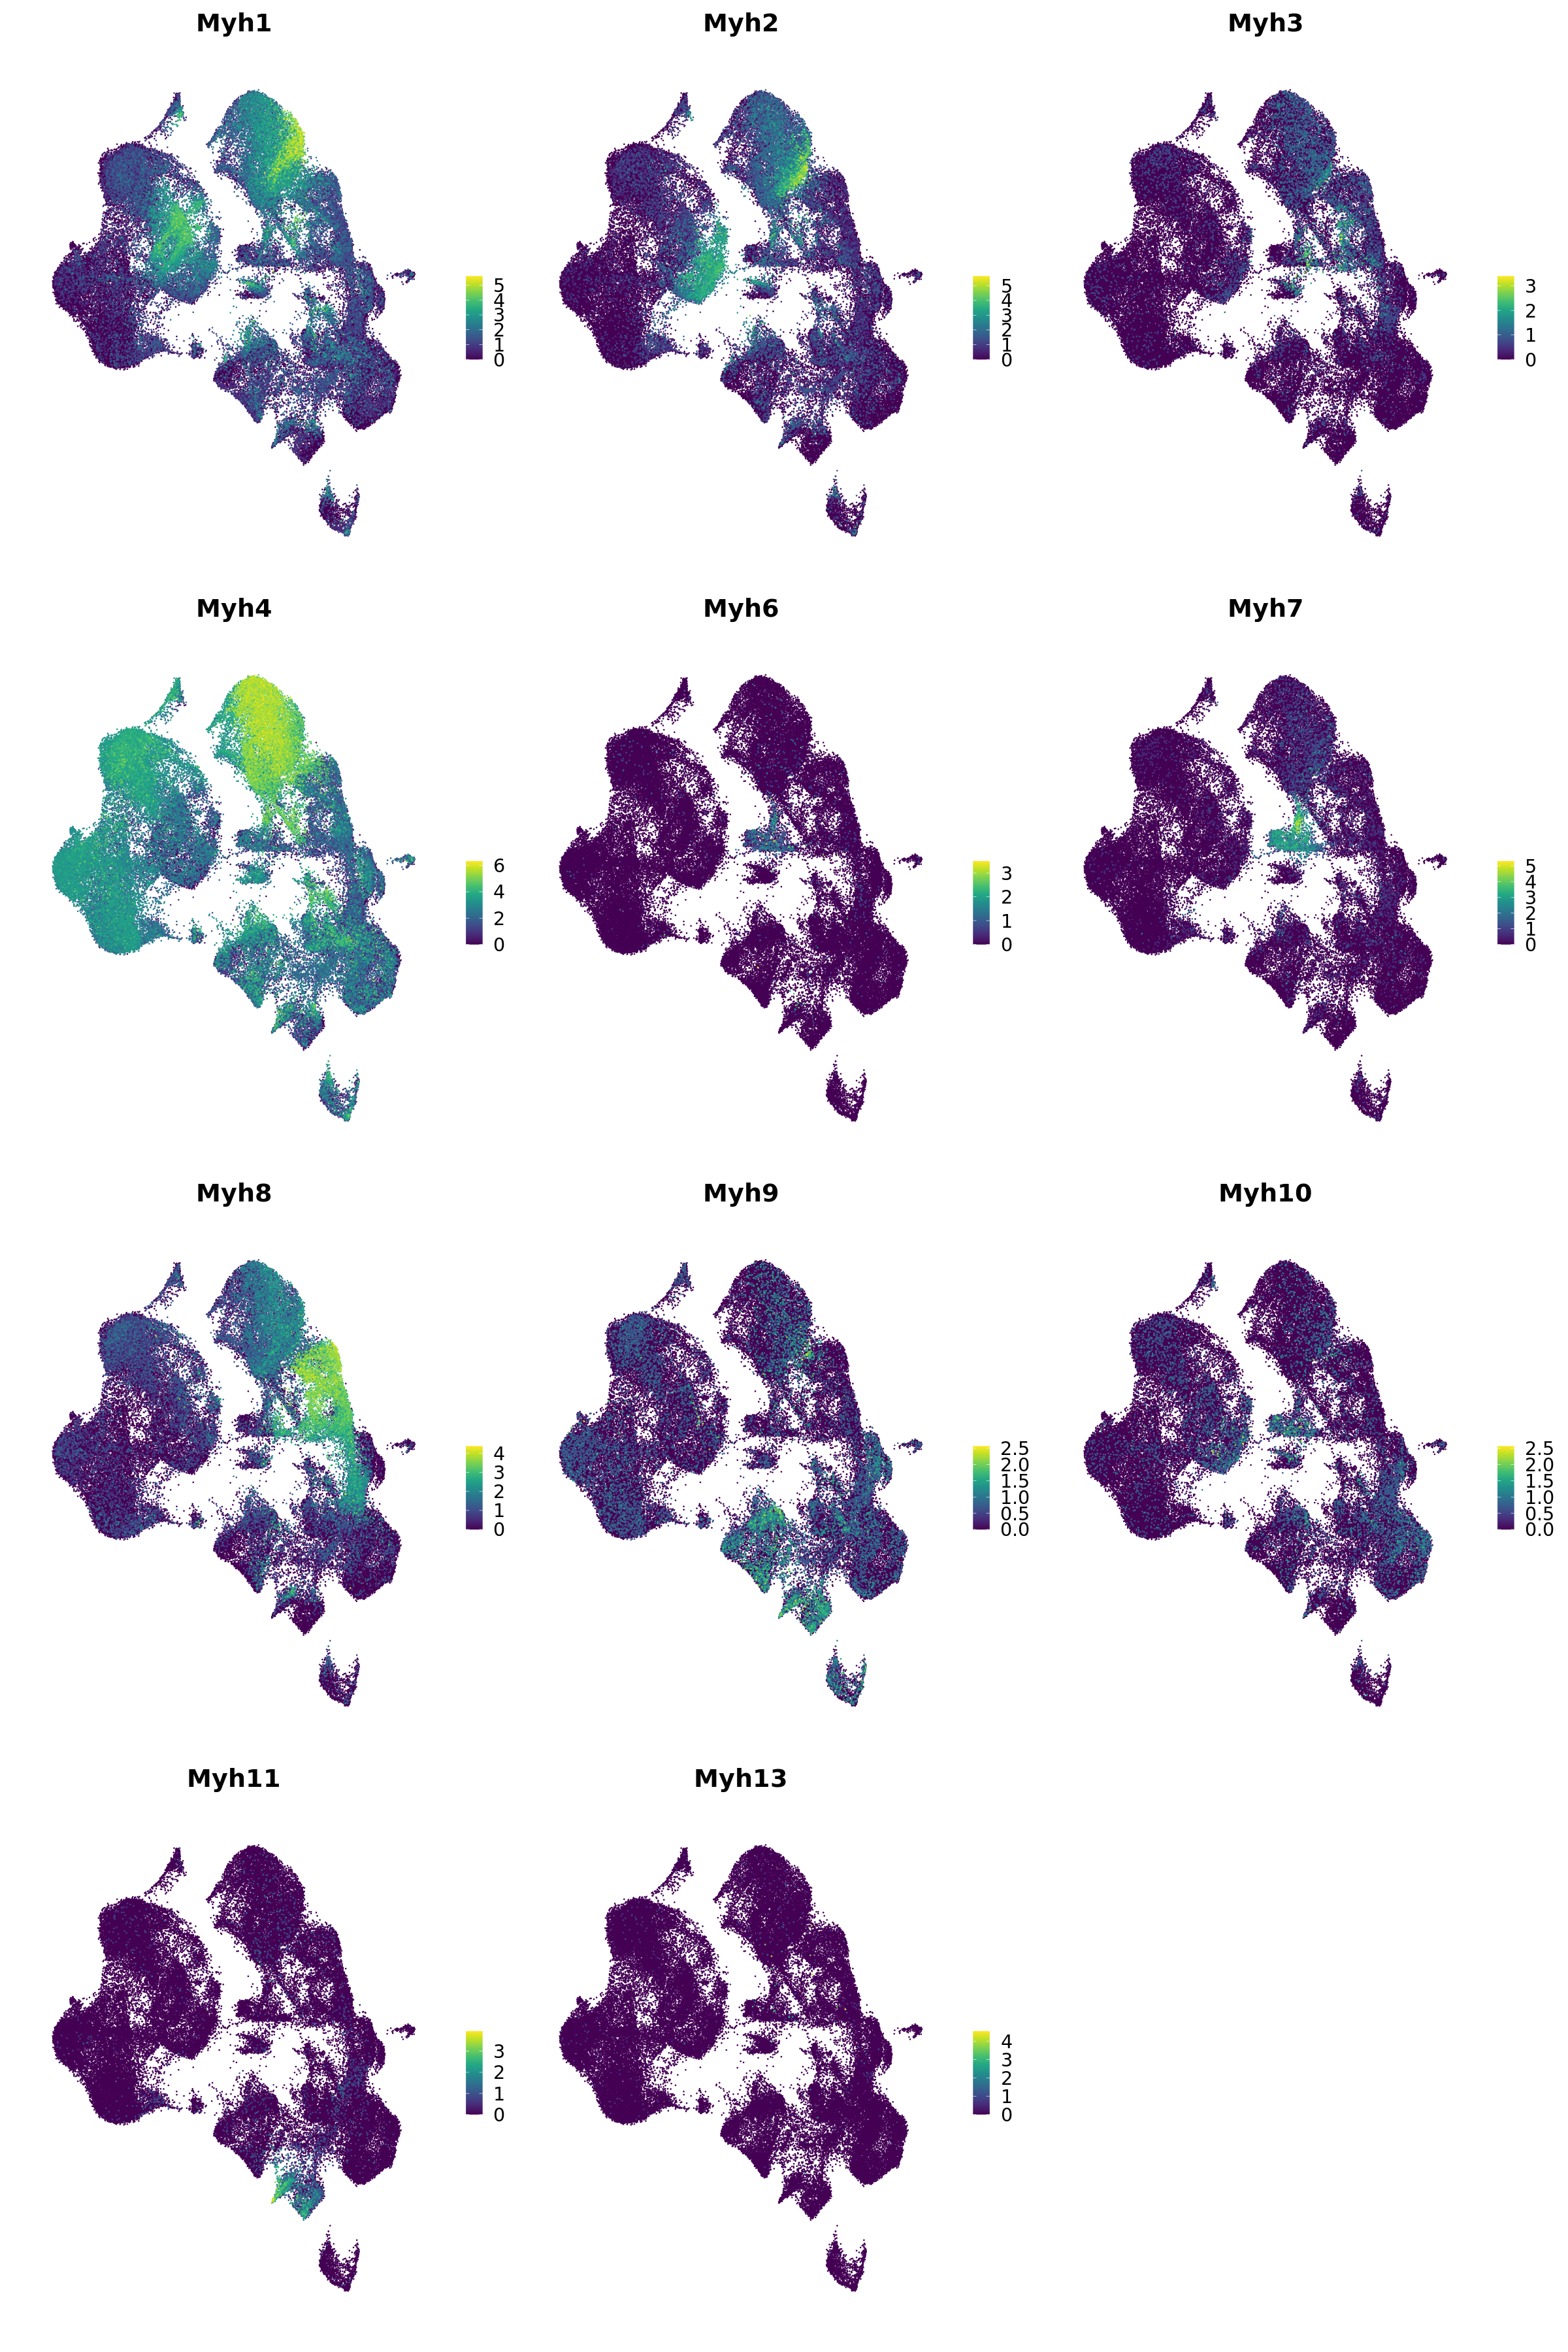

In [17]:
#pdf(file="plots/gastrocnemius/marker_featureplots.pdf",
#    width = 20, height = 40)

options(repr.plot.width=20, repr.plot.height=30)


DefaultAssay(combined.sct) = "SCT"
Idents(combined.sct) = "seurat_clusters"
Idents(combined.sct) = factor(Idents(combined.sct), levels = sort(as.character(unique(Idents(combined.sct)))))
FeaturePlot(combined.sct, pt.size = 0.1, order = T,
            features = genes, ncol =3) & scale_colour_gradientn(colours = viridis(11)) & NoAxes() & theme(text = element_text(size = 20))

#dev.off()

In [44]:
genes = read.csv("ref/mouse_gastroc_8celltype_markers.csv")

head(genes)


gene_id               gene_name     gene_type            p_val        
1 ENSMUSG00000026051.8  1500015O10Rik protein_coding       1.434273e-320
2 ENSMUSG00000101970.6  1810026B05Rik processed_transcript  1.142365e-30
3 ENSMUSG00000021458.17 2010111I01Rik protein_coding       9.038334e-136
4 ENSMUSG00000021458.17 2010111I01Rik protein_coding        5.849554e-79
5 ENSMUSG00000021458.17 2010111I01Rik protein_coding        6.108525e-51
6 ENSMUSG00000087380.7  2210408F21Rik processed_transcript  0.000000e+00
  p_val_adj     avg_log2FC pct.1 pct.2 celltype     
1 4.423870e-316 0.3434417  0.187 0.014 Tenocytes    
2  3.523512e-26 0.2696713  0.444 0.325 Macrophages  
3 2.787784e-131 0.4542002  0.472 0.334 Smooth_muscle
4  1.804236e-74 0.3752318  0.463 0.335 Tenocytes    
5  1.884113e-46 0.5312897  0.527 0.337 Schwann_cells
6  0.000000e+00 0.5881069  0.377 0.148 Myonuclei

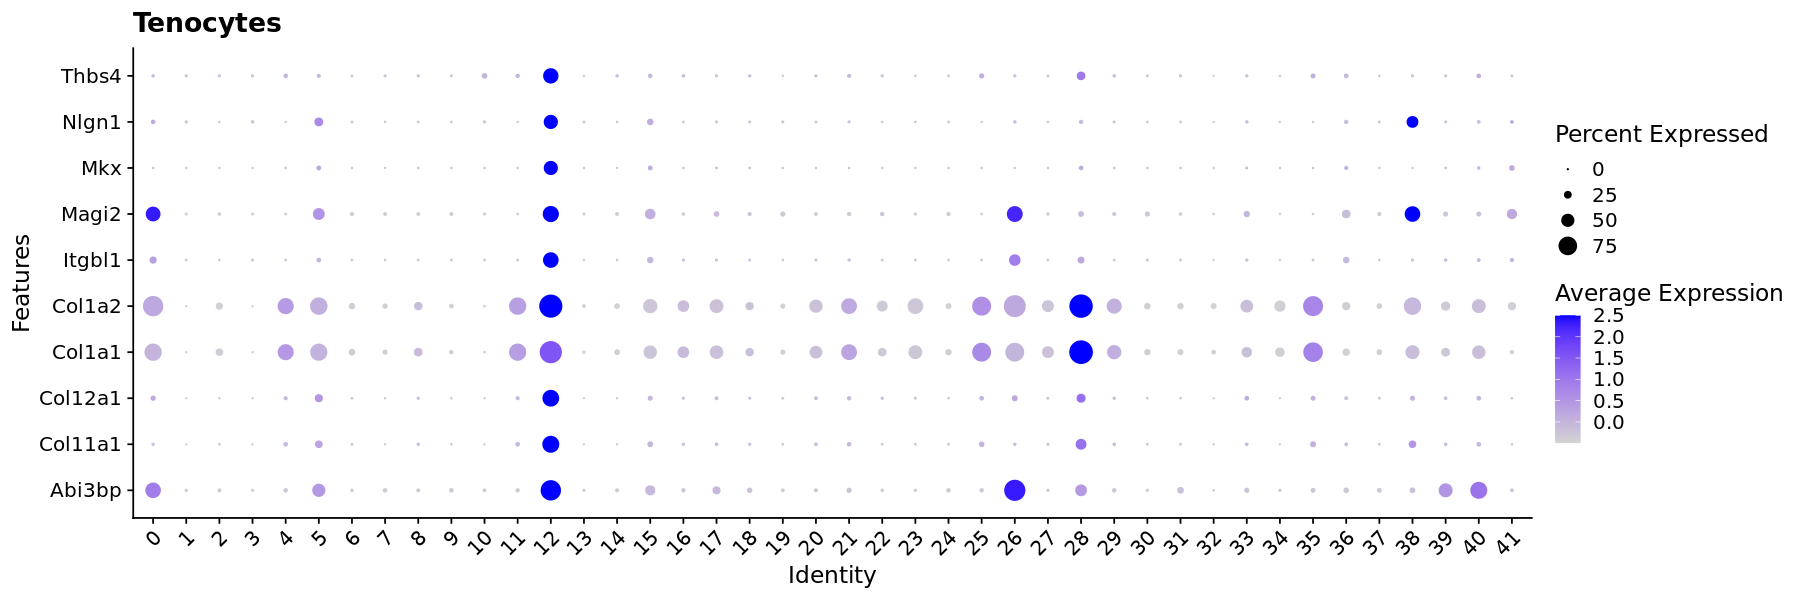

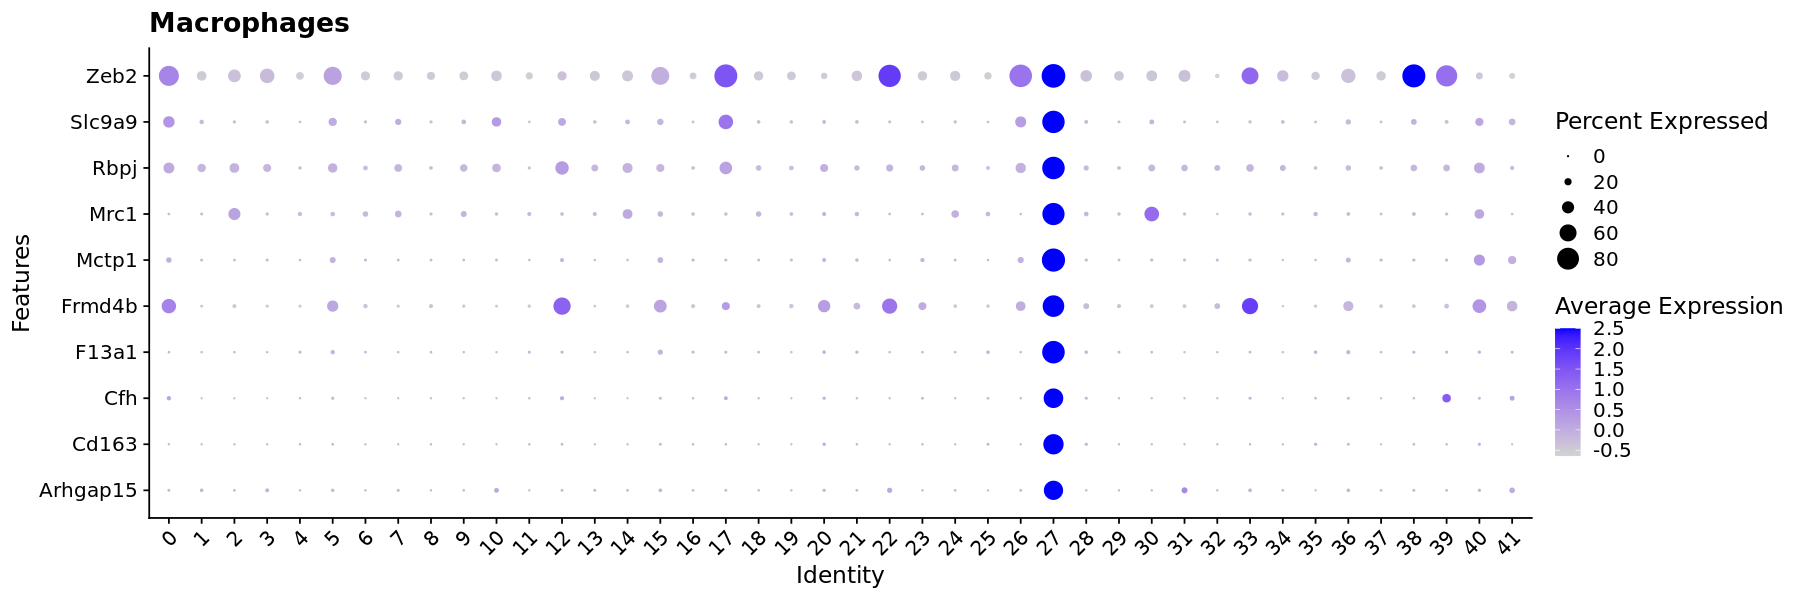

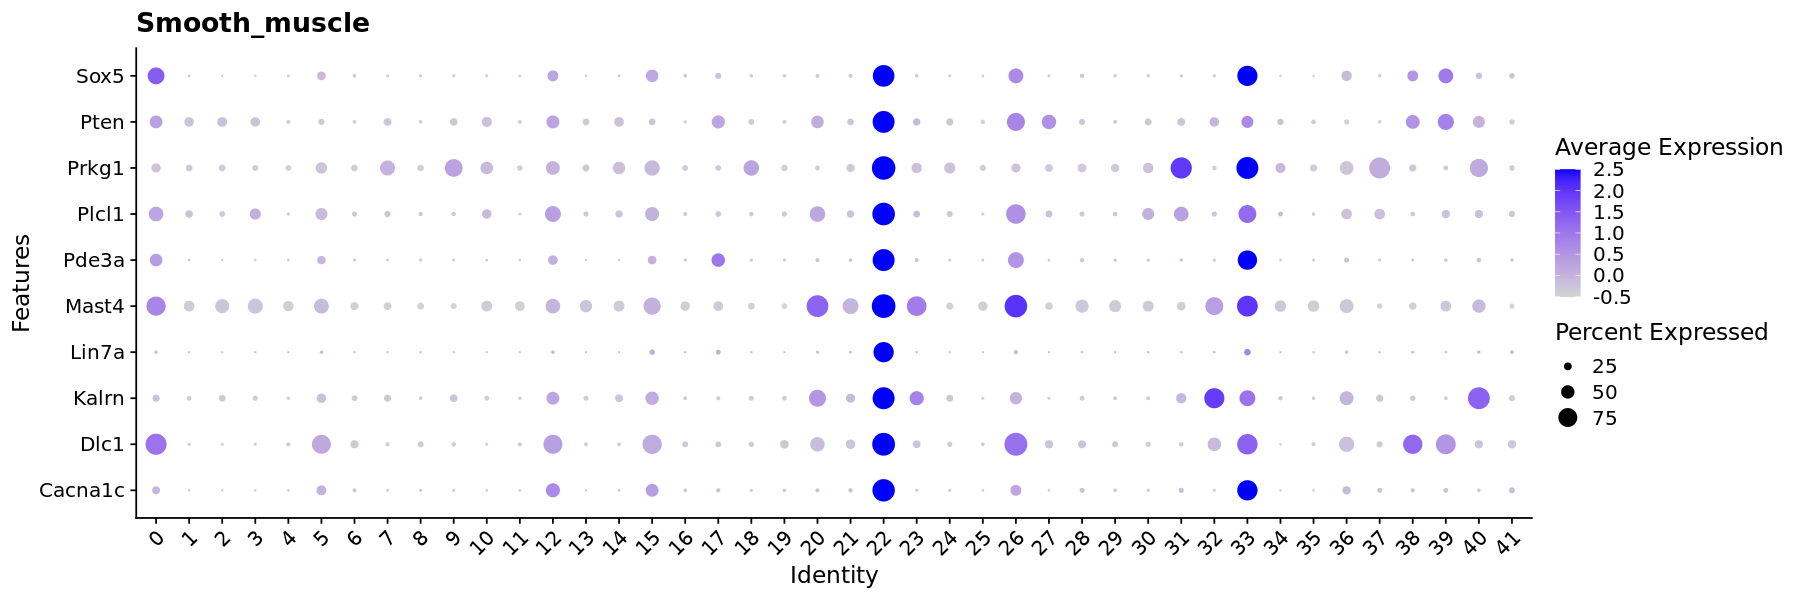

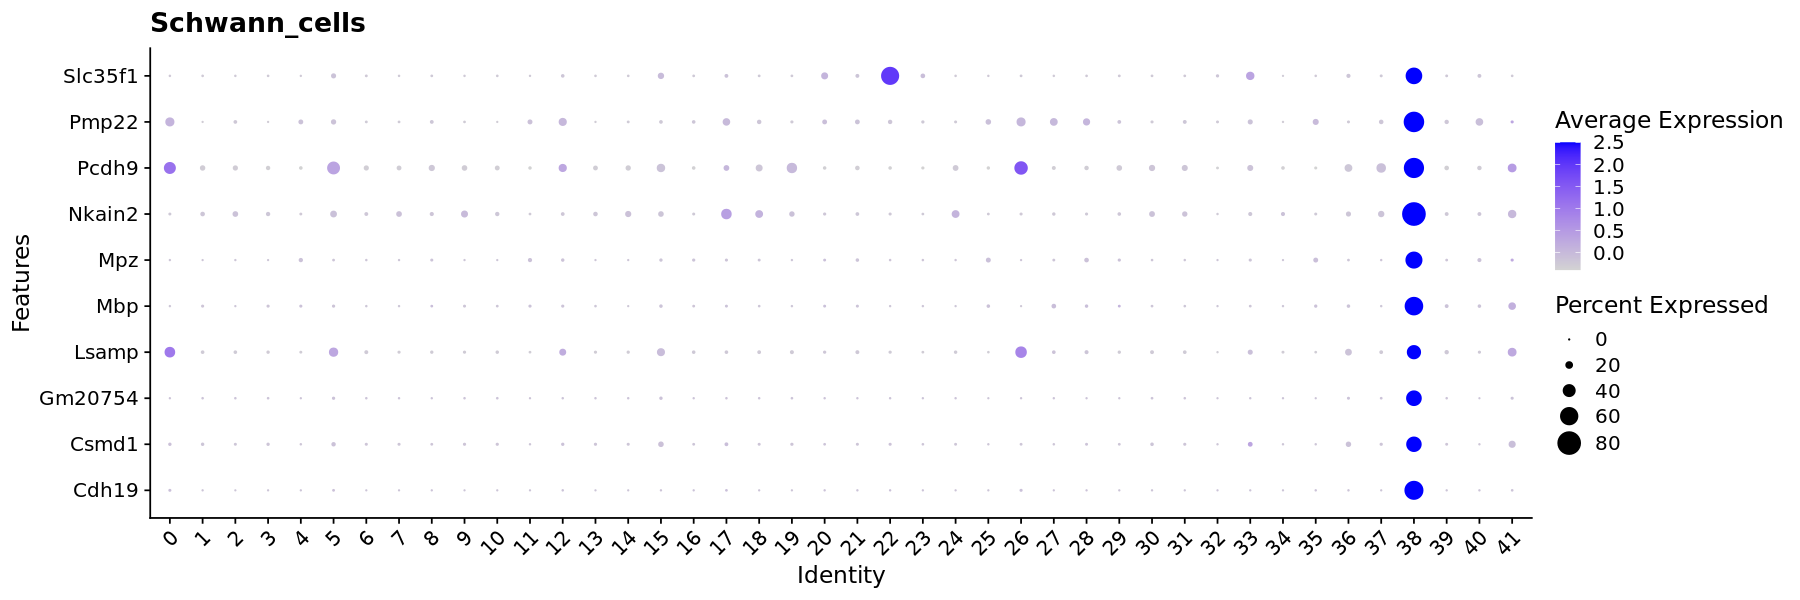

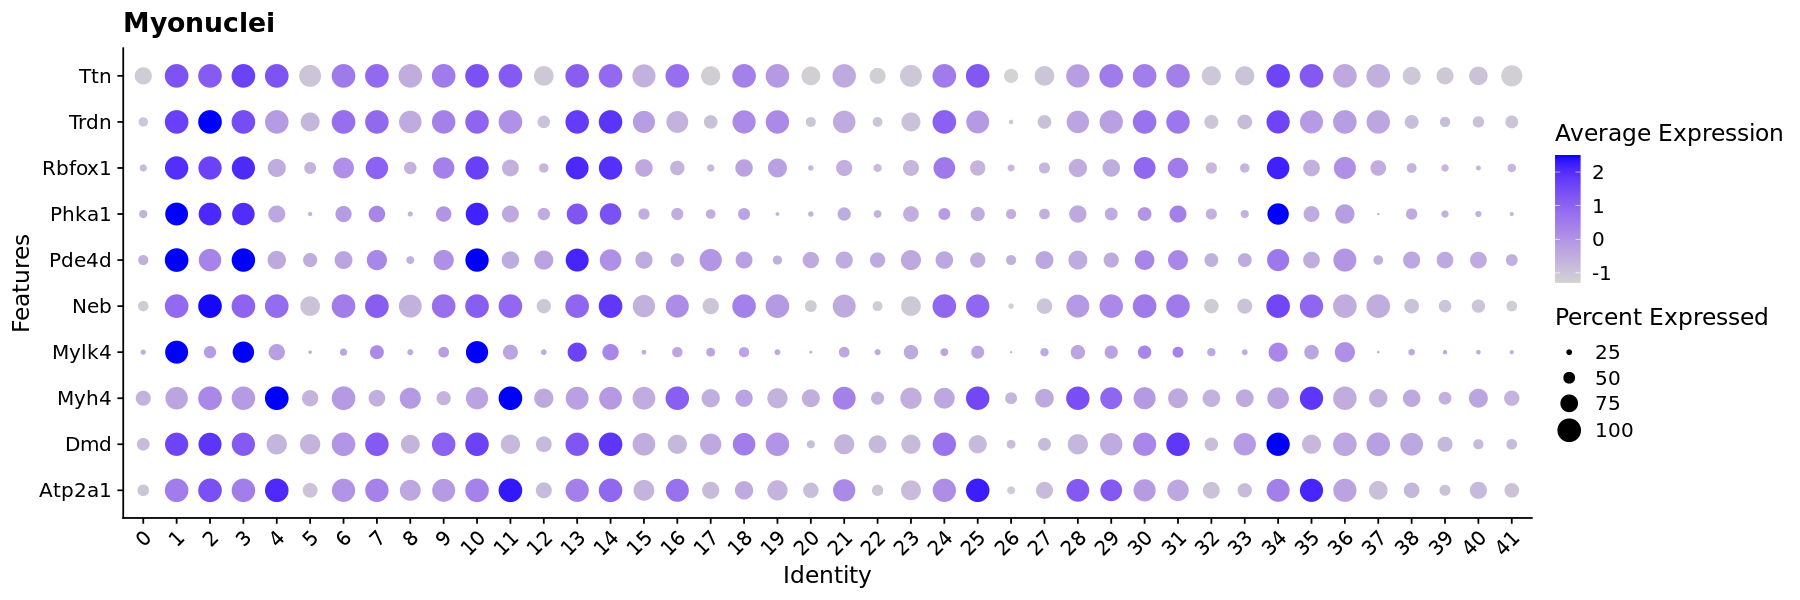

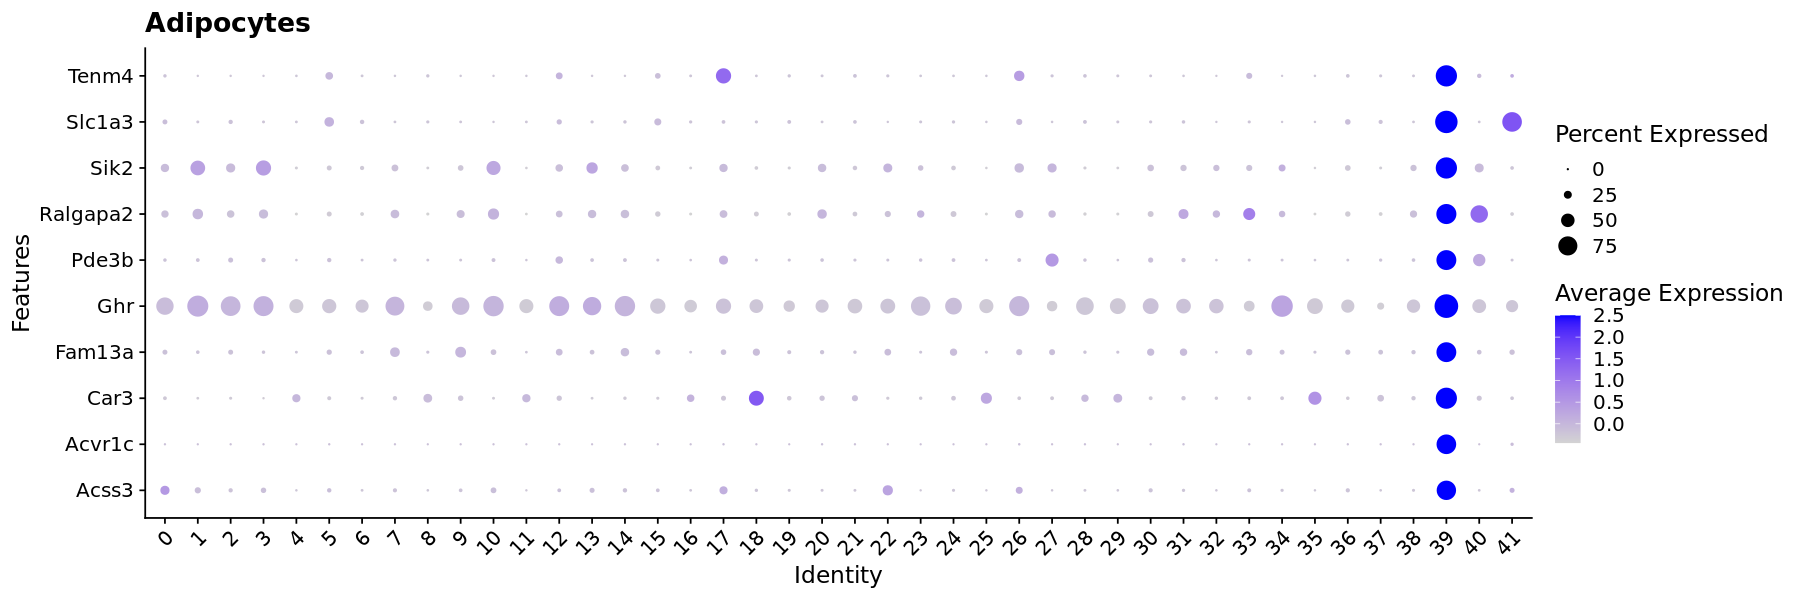

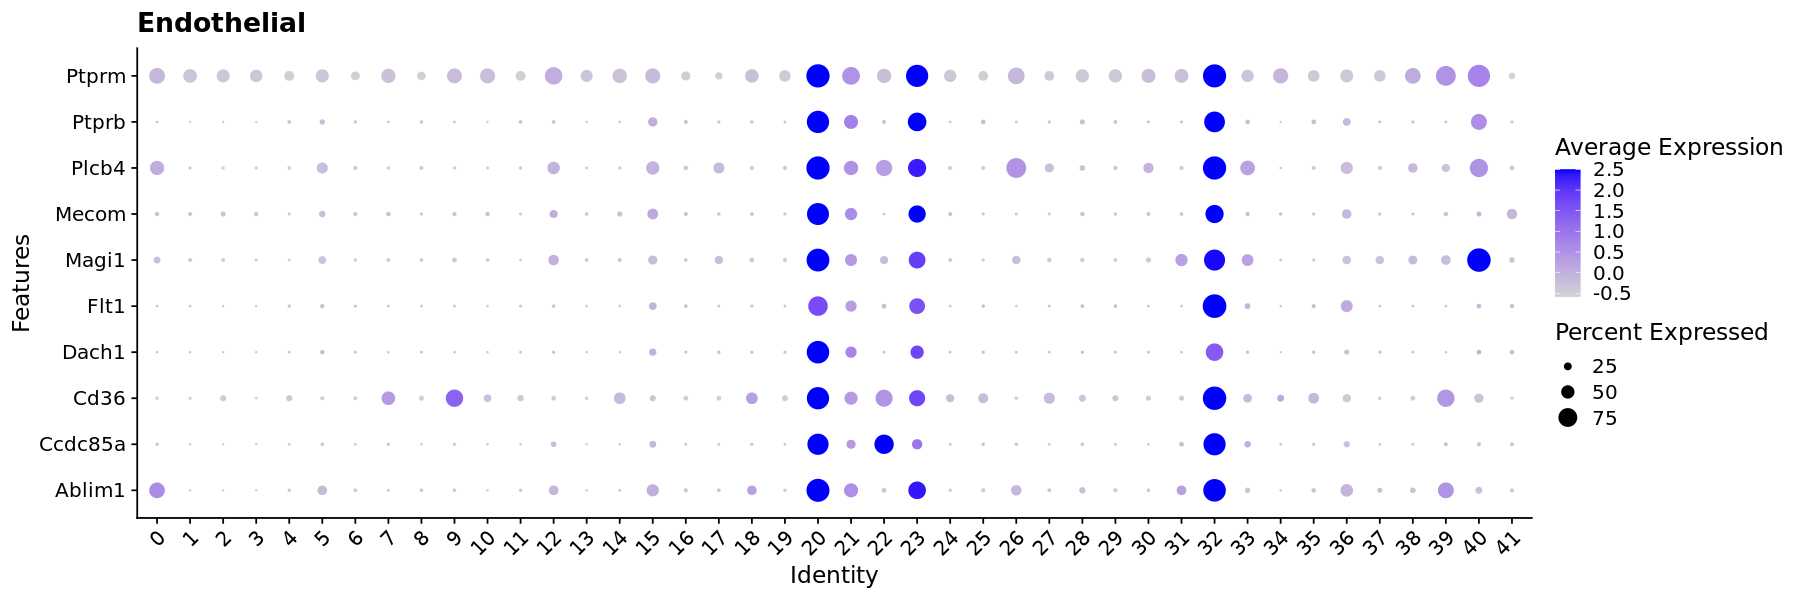

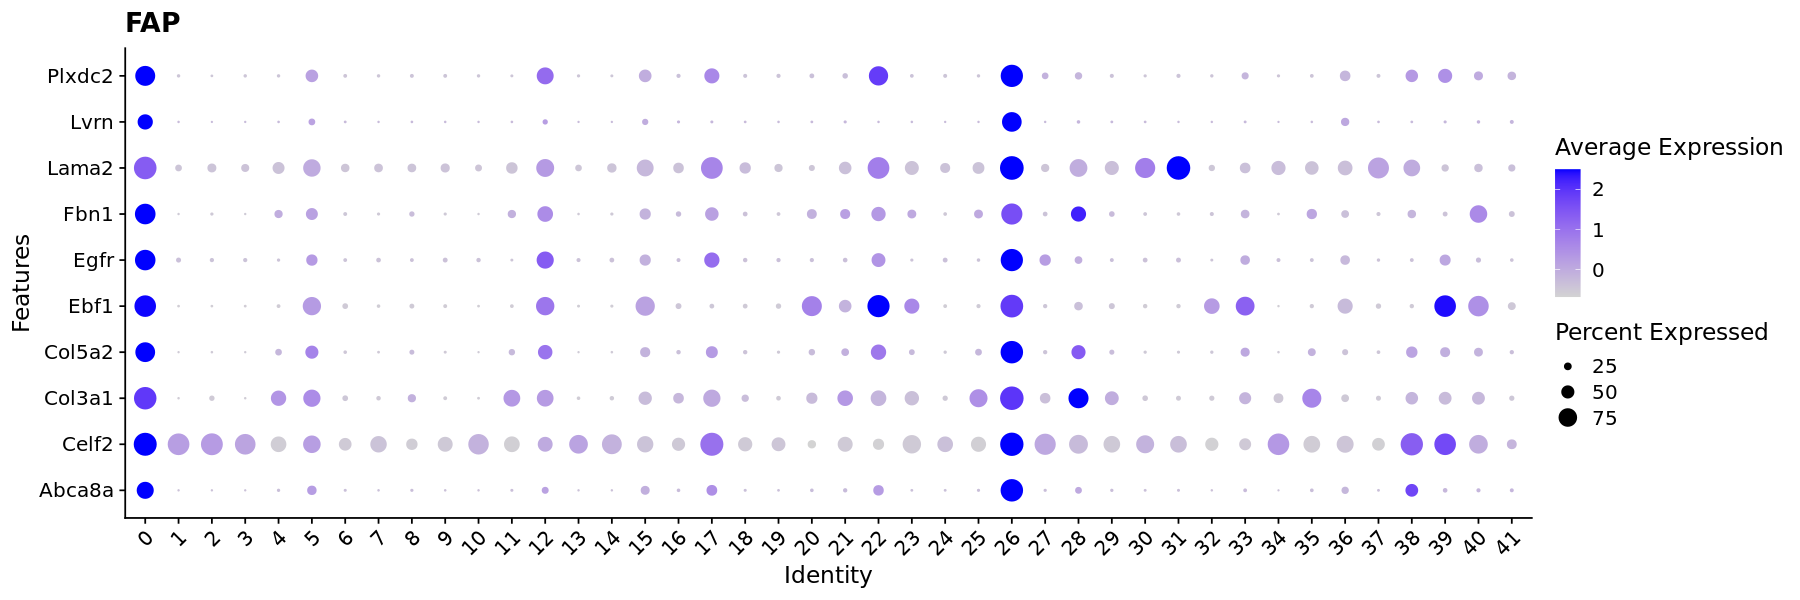

In [45]:
options(repr.plot.width=15, repr.plot.height=5)

DefaultAssay(combined.sct) = "SCT"
Idents(combined.sct) = "seurat_clusters"

genes %>%
    group_by(celltype) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10

for (celltype in unique(genes$celltype)){
    top10_celltype = top10[top10$celltype == celltype,]
    print(DotPlot(combined.sct, features = unique(top10_celltype$gene_name))+ 
          theme(axis.text.x = element_text(angle = 45, hjust = 1))  + coord_flip() + ggtitle(celltype))
}

## Manual subtypes annotation

In [51]:
combined.sct$subtypes = combined.sct$seurat_clusters
combined.sct$subtypes = gsub("\\<0\\>","FAP",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<1\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<2\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<3\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<4\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<5\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<6\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<7\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<8\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<9\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<10\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<11\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<12\\>","Tenocytes",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<13\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<14\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<15\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<16\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<17\\>","Satellite",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<18\\>","Type1",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<19\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<20\\>","Endothelial",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<21\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<22\\>","Smooth_muscle",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<23\\>","Endothelial",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<24\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<25\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<26\\>","FAP",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<27\\>","Macrophages",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<28\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<29\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<30\\>","NMJ",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<31\\>","MTJ",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<32\\>","Endothelial",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<33\\>","Smooth_muscle",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<34\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<35\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<36\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<37\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<38\\>","Schwann_cells",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<39\\>","Adipocytes",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<40\\>","Other",combined.sct$subtypes)
combined.sct$subtypes = gsub("\\<41\\>","Other",combined.sct$subtypes)


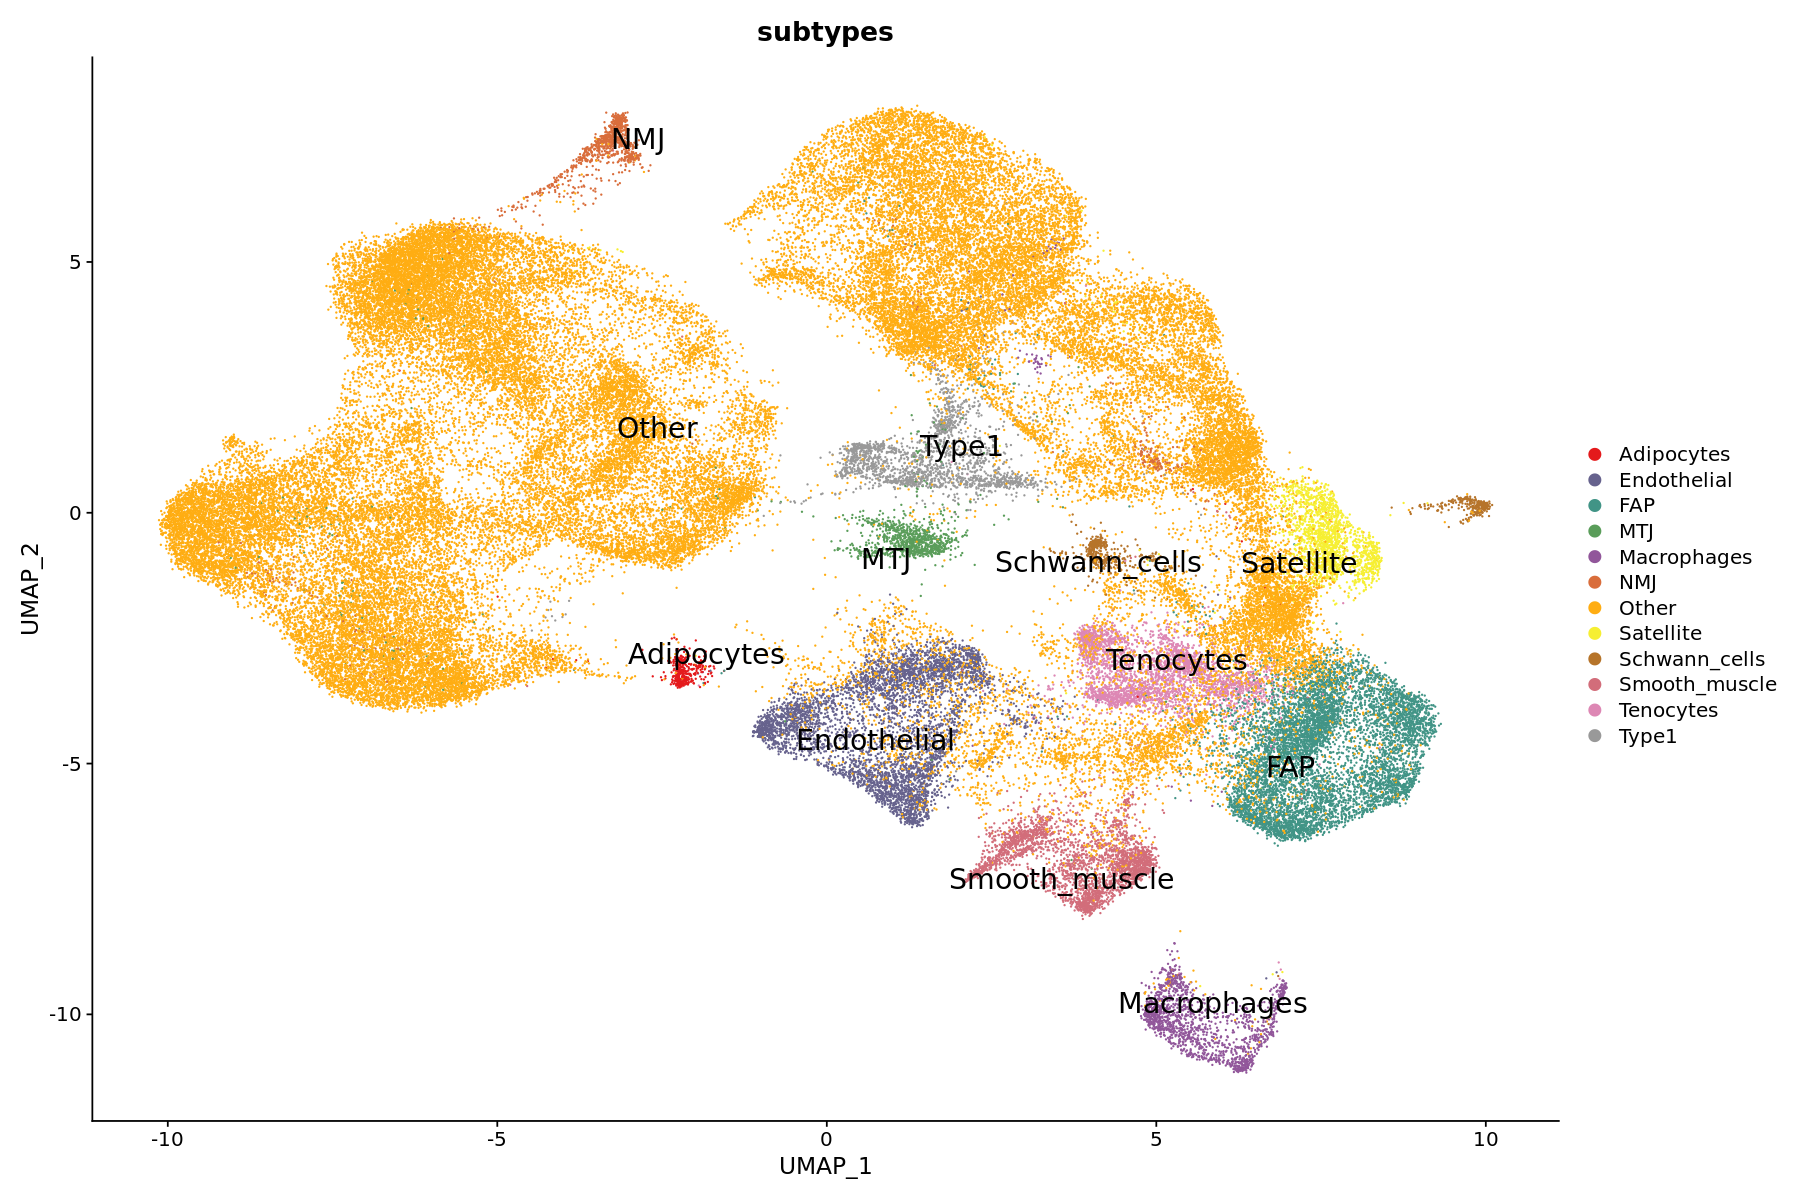

In [53]:
options(repr.plot.width=15, repr.plot.height=10)


nclusters = length(unique(combined.sct$subtypes))
cluster_cols = colorRampPalette(brewer.pal(9,"Set1"))(nclusters)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "subtypes", label = TRUE, label.size = 6, repel = TRUE, 
        cols = cluster_cols)


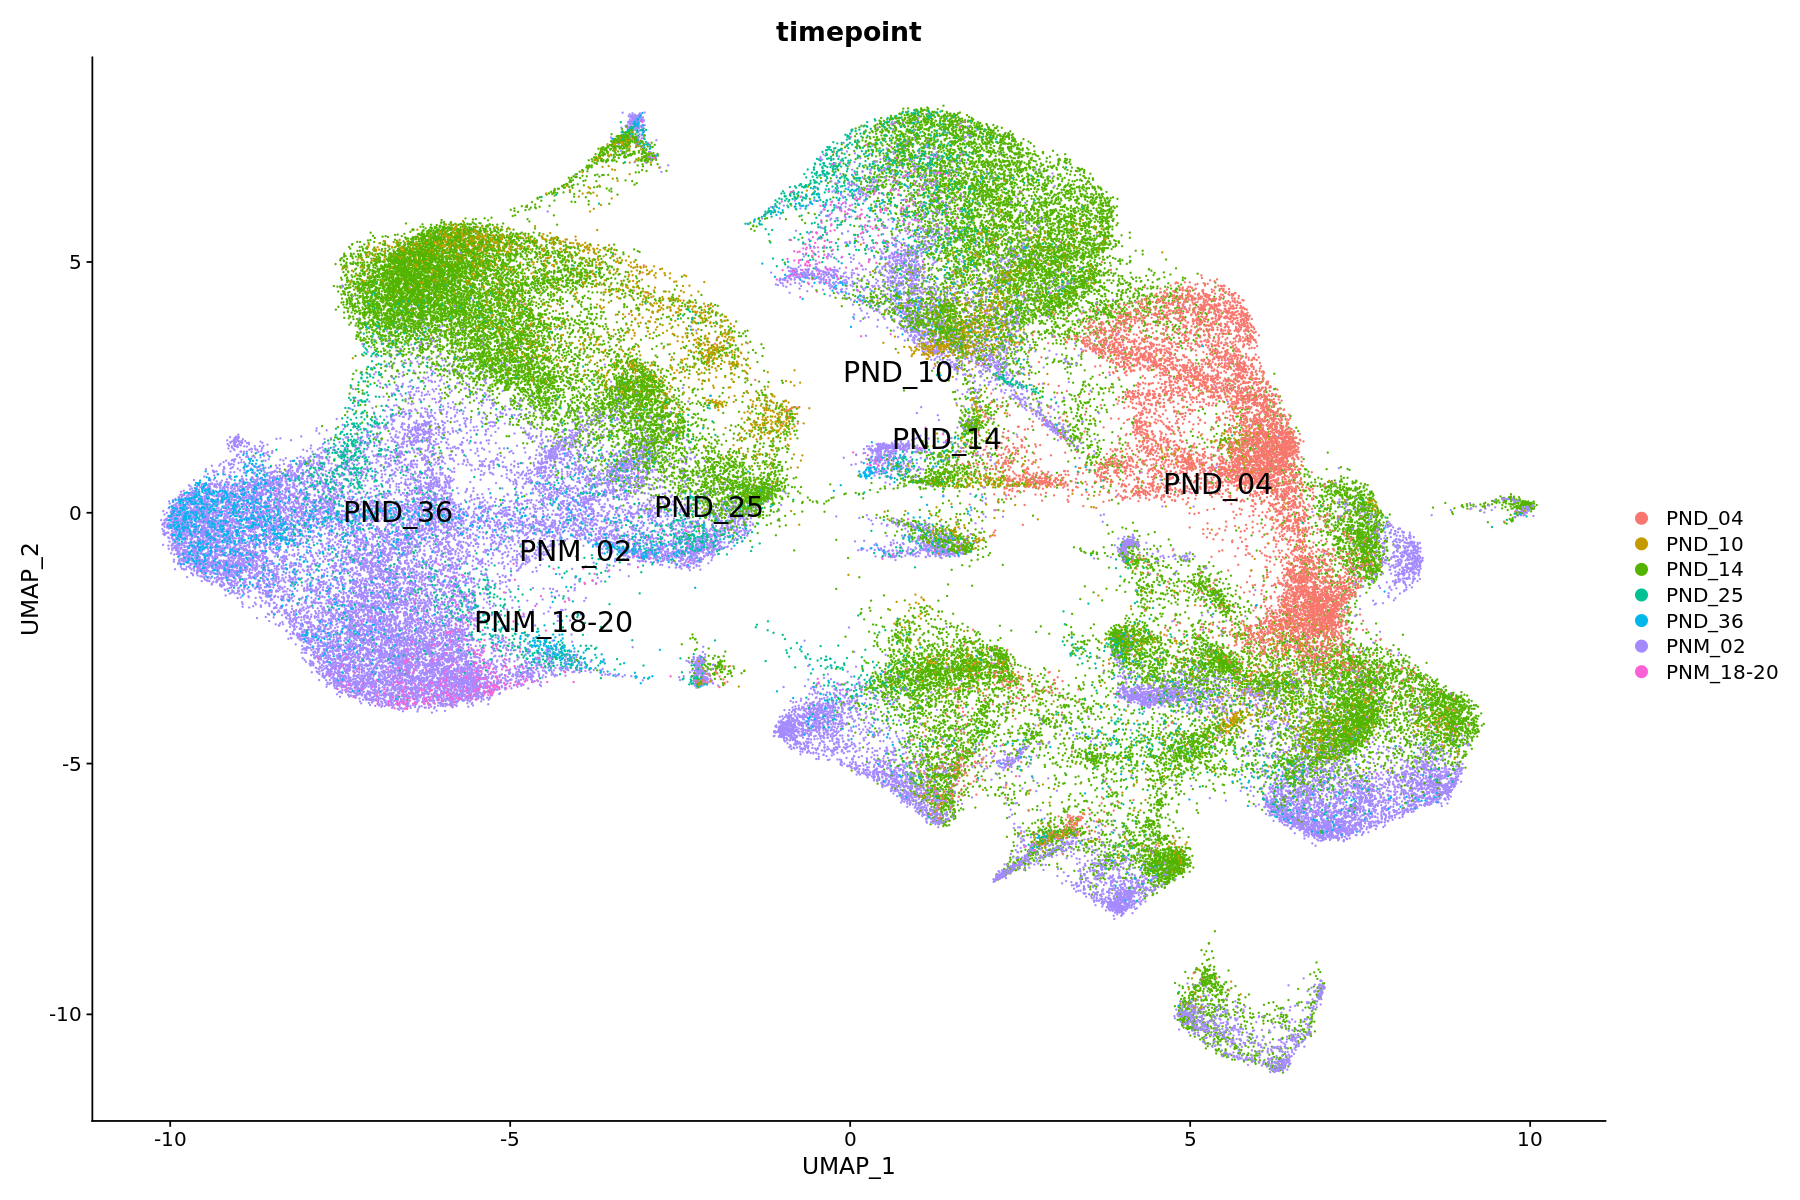

In [54]:

DimPlot(combined.sct, reduction = "umap", 
        group.by = "timepoint", label = TRUE, label.size = 6, repel = TRUE)


# Add celltypes and gen_celltypes metadata
Based on the subtypes annotation, we can group the cells into broader categories.

In [185]:
combined.sct$celltypes = combined.sct$subtypes

combined.sct$celltypes = gsub("\\<Cortex_ZG\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Cortex_ZF\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<X_zone\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Y_zone\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Cortex_cycling\\>","Cortex",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Medulla_NE\\>","Medulla",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Medulla_EPI\\>","Medulla",combined.sct$celltypes)
combined.sct$celltypes = gsub("\\<Endothelial_cycling\\>","Endothelial",combined.sct$celltypes)

combined.sct$gen_celltype = combined.sct$celltypes

combined.sct$gen_celltype = gsub("\\<Macrophages\\>","Myeloid",combined.sct$gen_celltype)


# Plotting the 3 levels of annotations

In [189]:
color_ref = read.csv("ref/enc4_mouse_snrna_celltypes_c2c12.csv")
gen_celltype_colors = unique(color_ref[color_ref$X...tissue == "Adrenal",c("gen_celltype","gen_celltype_color")])
rownames(gen_celltype_colors) = gen_celltype_colors$gen_celltype
gen_celltype_colors = gen_celltype_colors[sort(unique(combined.sct$gen_celltype)),]

pdf(file="plots/adrenal/UMAP_final_gen_celltype.pdf",
    width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "gen_celltype", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = gen_celltype_colors$gen_celltype_color)

dev.off()

png 
  2

In [190]:
celltype_colors = unique(color_ref[color_ref$X...tissue == "Adrenal",c("celltypes","celltype_color")])
rownames(celltype_colors) = celltype_colors$celltypes
celltype_colors = celltype_colors[sort(unique(combined.sct$celltypes)),]

pdf(file="plots/adrenal/UMAP_final_celltypes.pdf",
    width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "celltypes", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = celltype_colors$celltype_color)

dev.off()

png 
  2

In [191]:
subtype_colors = unique(color_ref[color_ref$X...tissue == "Adrenal",c("subtypes","subtype_color")])
rownames(subtype_colors) = subtype_colors$subtypes
subtype_colors = subtype_colors[sort(unique(combined.sct$subtypes)),]

pdf(file="plots/adrenal/UMAP_final_subtypes.pdf",
    width = 15, height = 10)

DimPlot(combined.sct, reduction = "umap", 
        group.by = "subtypes", 
        label = TRUE, label.size = 8, repel = TRUE,
       cols = celltype_colors$subtype_color)

dev.off()

png 
  2

## Proportion plot of celltypes over timepoint

In [192]:
combined.sct_parse = subset(combined.sct,subset= technology == "Parse")

samples = sort(unique(combined.sct_parse$timepoint))
dflist = list()
for (i in 1:length(unique(combined.sct_parse$timepoint))){
  tp=combined.sct_parse@meta.data[combined.sct_parse@meta.data$timepoint == samples[i],]
  #tp=tp[complete.cases(tp),]
  tp_df=as.data.frame(table(tp$celltypes))
  tp_df$percentage=tp_df$Freq/nrow(tp)
  tp_df$timepoint=rep(i,nrow(tp_df))
  dflist[[i]]=tp_df
}
df = do.call(rbind, dflist)
df <- df[order(df$timepoint),]
colnames(df)= c("celltypes","Freq","percentage","timepoint")



In [193]:
pdf(file="plots/adrenal/timepoint_celltypes_proportions.pdf",
    width = 15, height = 10)

ggplot(df, aes(x=timepoint, y=percentage, fill=celltypes)) + 
  geom_area()  +
  scale_fill_manual(values= celltype_colors$celltype_color) + 
  scale_x_continuous(breaks = c(1,2,3,4,5,6,7),labels= c("PND_04","PND_10","PND_14",
                                                         "PND_25","PND_36","PNM_02","PNM_18-20"))+
  scale_y_continuous(breaks = c(0,0.1,0.2,0.3,0.4,0.5,
                                0.6,0.7,0.8,0.9,1.0),labels= c("0%","10%","20%","30%","40%","50%","60%","70%","80%","90%","100%")) + 
theme_minimal()+theme(text = element_text(size = 30)) + 
theme(axis.text.x = element_text(size = 30))  + 
theme(axis.text.y = element_text(size = 30))   + 
theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
dev.off()

png 
  2

In [18]:
saveRDS(combined.sct,file="seurat/adrenal_Parse_10x_integrated.rds")
